# Klasifikácia pomocou rozhodovacích stromov

Rozhodovacie stromy patria medzi populárne metódy klasifikácie. Medzi podstatné vlastnosti, kvôli ktorým sú klasifikátory na báze rozhodovacích stromov obľúbené, je ich interpretovateľnosť. Stromy predstavujú dobre pochopiteľnú a zároveň prezentovateľnú štruktúru, ktorá môže byť vhodná, ak je potrebné vnútornú štruktúru modelu (a teda aj spôsob, ako model "dospel" k danému výsledku) vysvetliť alebo prezentovať. 

Klasifikátor rozhodovacích stromov je v knižnici Scikit-learn implementovaný triedou `DecisionTreeClassifier`. 

Aj napriek faktu, že mnoho algoritmov pre indukciu rozhodovacích stromov je schopných pracovať s kategorickými atribútmi, implementácia tohoto klasifikátora v Scikit-learn bohužiaľ s kategorickými premennými pracovať nevie. Dáta je preto nutné predspracovať, transformovaním kategorických atribútov na numerické. Odporúča sa na všetky atribúty bez usporiadania transformovať pomocou One Hot Encoderu. 

Okrem toho, z datasetu v prípade rozhodovacích stromov môžeme odstrániť irelevantné a redundantné atribúty. V prípade datasetu Titanic teda môžeme odstrániť atribúty `age_ordinal` a `fare_ordinal`, keďže vznikli odvodením z existujúcich atribútov `age` a `fare`. 

Rozhodovacie stromy ale nevyžadujú normalizáciu atribútov.

In [6]:
# Titanic import a preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


titanic = pd.read_csv("../data/titanic-processed.csv")

titanic = titanic.drop(columns=['cabin','ticket','title','deck','fare_ordinal','age_ordinal'])

titanic['sex'] = titanic['sex'].map({"male": 0, "female": 1})
titanic['has_family'] = titanic['has_family'].map({False: 0, True: 1})

titanic = pd.get_dummies(titanic, columns=['embarked', 'title_short'])

titanic.head()

,pclass,survived,sex,age,sibsp,parch,fare,family,has_family,embarked_Cherbourg,embarked_Queenstown,embarked_Southampton,title_short_Miss,title_short_Mr,title_short_Mrs,title_short_rare title
0,1,1,1,29.00,0,0,211.3375,0,0,0,0,1,1,0,0,0
1,1,1,0,0.92,1,2,151.5500,3,1,0,0,1,0,0,0,1
2,1,0,1,2.00,1,2,151.5500,3,1,0,0,1,1,0,0,0
3,1,0,0,30.00,1,2,151.5500,3,1,0,0,1,0,1,0,0
4,1,0,1,25.00,1,2,151.5500,3,1,0,0,1,0,0,1,0


In [7]:
X_titanic = titanic.drop('survived', axis=1) # vytvoríme maticu príznakov - použijeme všetky stĺpce okrem cieľového atribútu a uložíme do X_titanic
y_titanic = titanic['survived'] # vytvoríme vektor hodnôt cieľového atribútu ako stĺpec 'survived'

print(X_titanic.shape) # pre kontrolu môžeme vypísať rozmery matice hodnôt a vektora cieľového atribútu
print(y_titanic.shape)

from sklearn.model_selection import train_test_split # importujeme funkciu train_test_split()
X_train, X_test, y_train, y_test = train_test_split(X_titanic, y_titanic, test_size=0.3, random_state=1) # rozdelíme dataset do trénovacej a testovacej časti, tak že testovacia bude 30% z celkového datasetu

(1309, 15)
(1309,)


Model klasifikátora na báze rozhodovacích stromov potom trénujeme podobne, ako v prípade modelu k-NN. Použijeme triedu `DecisionTreeClassifier`, inicializujeme model (prípadne nastavíme parametre modelu) a model natrénujeme na trénovacích dátach. 

Pri učení stromového modelu môžeme model nastavovať nasledovými parmetrami:
* criterion - kritérium pre výber atribútu: "gini" alebo "entropy"
* max_depth - maximálna hĺbka stromu (ak je nastavená na None, expanduje sa kompletný strom)
* min_samples_split - najmenší počet príkladov potrebných pre vetvenie uzlu
* min_samples_leaf - najmenší možný počet príkladov v listovom uzle
* presort - True/False - utriedenie atribútov pre urýchlenie trénovania

In [8]:
from sklearn.tree import DecisionTreeClassifier # Importovanie triedy zodpovedajúcej modelu, ktorý budeme trénovať
from sklearn.metrics import confusion_matrix

dt = DecisionTreeClassifier(max_depth=3)   # Inicializácia stromového modelu   
dt.fit(X_train, y_train)        # Trénovanie modelu na trénovacej množine 
y_dt = dt.predict(X_test)       # Otestovanie modelu na testovacej množine

from sklearn.metrics import accuracy_score,precision_score, recall_score # vypočítanie metrík kvality modelu

print(f"Presnosť (accuracy) modelu: {accuracy_score(y_test, y_dt)}")
print(f"Presnosť (precision) modelu: {precision_score(y_test, y_dt)}")
print(f"Návratnosť (recall) modelu: {recall_score(y_test, y_dt)}")

cm = confusion_matrix(y_test, y_dt)  # vypísanie kontigenčnej tabuľky
print(cm)

Presnosť (accuracy) modelu: 0.821882951653944
Presnosť (precision) modelu: 0.7919463087248322
Návratnosť (recall) modelu: 0.7515923566878981
[[205  31]
 [ 39 118]]


#### Zobrazenie stromového modelu

Ako sme na úvod spomínali, stromový model je možné vizualizovať, čo je podstatné pre pochopenie modelu a spôsobu jeho fungovania. Na druhej strane - podstatný faktor je ale zložitosť samotného modelu. Priveľmi rozvetvené stromy, s veľmi bohatou štruktúrou sú veľmi ťažko čitateľné a neprehľadné, čím strácajú tento benefit. 

Skúsme sa pozrieť, asi ako vyzerá rozhodovací strom pre implicitne nastavený stromový klasifikátor natrénovaný na trénovacích dátach datasetu Titanic.

V jazyku Python a knižnici Scikit-learn existuje niekoľko spôsobov, ako stromové modely vizualizovať. Väčšina zahŕňa inštaláciu externých progamov ako GraphViz, resp. rôznych ďalších modulov, preto pre účely cvičenia použijeme iba export stromu do súboru v GraphViz formáte. Vytvorený súbor (súbor s príponou `.dot`) môžeme potom otvoriť a strom zobraziť vo webovej verzii aplikácie GraphViz. Tá je dostupná na www.webgraphivz.com.

Na export natrénovaného rozhodovacieho stromu použijeme funkciu Scikit-learn `export_graphviz()`. Tej špecifikujeme ako parameter stromový model, ktorý chceme vykresliť, `feature_names` obsahujúci zoznam hlavičiek atribútov (kvôli vykresľovaniu uzlov), `class_names` obsahujúci zoznam hodnôt cieľového atribútu a výstupný súbor, do ktorého vizualizáciu uložíme.

In [16]:
from sklearn import tree
from sklearn.tree import export_graphviz

with open("decision_tree.txt", "w") as f:
    f = tree.export_graphviz(dt, feature_names=X_titanic.columns.values, class_names=['0','1'], out_file=f)

Po spustení tohoto odstavca uvidíte v prehliadači súborov Jupyter Labu vľavo súbor `decision_tree.txt`. Otvorte ho (dá sa otvoriť aj priamo v Jupyter prostredí) a skopírujte jeho kompletný obsah do okna webovej aplikácie www.webgraphviz.com. V nej po stlačení tlačidla Generate Graph vygenerujete vizualizáciu rozhodovacieho stromu. Preskúmajte ju. 

#### Úloha 12.2.

Ak je výsledný strom príliš zložitý a nečitateľný - ktorý z parametrov by ste použili a s akou hodnotou, aby ste vygenerovali všeobecnejší a prehľadnejší strom? Upravte kód trénovania modelu a natrénujte model s identifikovaným a nastaveným parametrom a natrénujte takýto model. Potom ho vizualizujte a porovnajte s modelom natrénovaným bez nastavení parametrov.

### Reprezentácia modelu pomocou pravidiel

Rozhodovacie stromy okrem vizualizácie umožňujú odlišný spôsob prezentácie štruktúry modelu - a to tak, že zo štruktúry stromu vygenerujeme pravidlá. Takéto pravidlá môžu byť v tvare `if` podmienka `then` záver. Môžu byť extrahované priamo zo štruktúry stromu a zodpovedajú jednotlivým testom (podmienka) a vetveniam (závery). 

Nižšie je kód funkcie `tree_to_code`, ktorú môžeme použiť na pretransformovanie stromovej štruktúry do pravidiel. Funkcia obsahuje implementované odsadenie vypisovania textu časti pravidiel pre zlepšenie citateľnosti výstupu.

Spustite funkciu na vytvorenom stromovom modeli a porovnajte extrahované pravidlá so stromovou štruktúrou:

In [17]:
from sklearn.tree import _tree

def tree_to_code(tree, feature_names): 

	tree_ = tree.tree_
	feature_name = [
		feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
		for i in tree_.feature
	]
	print("def tree({}):".format(", ".join(feature_names)))

	def recurse(node, depth):
		indent = "  " * depth
		if tree_.feature[node] != _tree.TREE_UNDEFINED:
			name = feature_name[node]
			threshold = tree_.threshold[node]
			print("{}if {} <= {}:".format(indent, name, threshold))
			recurse(tree_.children_left[node], depth + 1)
			print("{}else:  # if {} > {}".format(indent, name, threshold))
			recurse(tree_.children_right[node], depth + 1)
		else:
			print("{}return {}".format(indent, tree_.value[node]))

	recurse(0, 1)

In [18]:
# zavoláme funkciu tree_to_code na vytvorenom modeli dt, názvy atribútov sú X_titanic.column.values

tree_to_code(dt, X_titanic.columns.values)

def tree(pclass, sex, age, sibsp, parch, fare, family, has_family, embarked_Cherbourg, embarked_Queenstown, embarked_Southampton, title_short_Miss, title_short_Mr, title_short_Mrs, title_short_rare title):
  if title_short_Mr <= 0.5:
    if pclass <= 2.5:
      if sex <= 0.5:
        return [[14. 18.]]
      else:  # if sex > 0.5
        return [[ 12. 160.]]
    else:  # if pclass > 2.5
      if family <= 3.5:
        return [[67. 77.]]
      else:  # if family > 3.5
        return [[33.  2.]]
  else:  # if title_short_Mr > 0.5
    if pclass <= 1.5:
      if age <= 49.5:
        return [[50. 33.]]
      else:  # if age > 49.5
        return [[21.  3.]]
    else:  # if pclass > 1.5
      if fare <= 51.69790077209473:
        return [[366.  45.]]
      else:  # if fare > 51.69790077209473
        return [[10.  5.]]


Dôležitosť atribútov pre klasifikáciu vieme spočítať aj separátne. Môžeme na to použiť napr. funkciu `SelectKBest`, pomocou ktorej vieme odfiltrovať `k` najpodstatnejších atribútov pre tvorbu modelu. Vieme ju takisto použiť pre spočítanie dôležitosti atribútov a selekciu spraviť manuálne. 

In [10]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

fs = SelectKBest(score_func=mutual_info_classif, k='all')
fs.fit(X_train, y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_classif at 0x000001AEF17DADC8>)

Dôležitosť atribútov potom vieme vypísať na obrazovku alebo vykresliť do grafu. 

Atribut 0: 0.049510
Atribut 1: 0.137638
Atribut 2: 0.009085
Atribut 3: 0.024994
Atribut 4: 0.000000
Atribut 5: 0.133421
Atribut 6: 0.018794
Atribut 7: 0.020018
Atribut 8: 0.013460
Atribut 9: 0.002963
Atribut 10: 0.000000
Atribut 11: 0.037663
Atribut 12: 0.143120
Atribut 13: 0.050677
Atribut 14: 0.000698


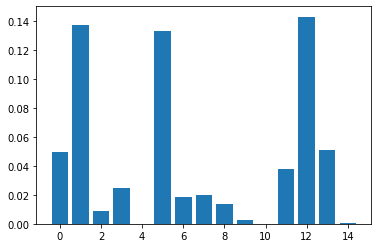

In [11]:
for i in range(len(fs.scores_)):
	print('Atribut %d: %f' % (i, fs.scores_[i]))
    
    
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

#### Úloha 12.3.

Použite Grid Search pre nájdenie optimálnej kombinácie parametrov modelu rozhodovacieho stromu na dátach Titanic. V Grid Search použite 5-násobnú krížovú validáciu a ako metriku vyhodnotenia použite `accuracy`. Identifikujte najlepší model vypíšte preň metriky presnosti a návratnosti (vypíšte aj kontigenčnú tabuľku - confusion matrix).

In [2]:
# YOUR CODE HERE
from sklearn.model_selection import GridSearchCV 

# naplnime si najprv zoznamy jednotlivych hodnot parametrov pre algoritmus rozhodovacich stromov

criterion_range = ['gini', 'entropy'] # kritérium pre výber atribútu: "gini" alebo "entropy"
max_depth_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # maximálna hĺbka stromu (ak je nastavená na None, expanduje sa kompletný strom)
min_samples_split_range = [2, 4, 8, 10] # najmenší počet príkladov potrebných pre vetvenie uzlu
min_samples_leaf_range = [1, 5, 10, 15] # najmenší možný počet príkladov v listovom uzle
presort_range = [True, False] # True/False - utriedenie atribútov pre urýchlenie trénovania

# teraz z hodnot parametrov vytvorime param_grid
param_grid = dict(criterion=criterion_range, max_depth=max_depth_range, min_samples_split = min_samples_split_range, min_samples_leaf = min_samples_leaf_range, presort = presort_range )
print(param_grid)

# inicializujeme stromovy klasifikator bez nastaveni parametrov, ktore chceme hladat Grid Searchom
dtree = DecisionTreeClassifier()

# nastavime samotny Grid Search - model dtree vytvoreny predoslym prikazom, predame mu nastavene pole parametrov a nastavime validaciu a metriku
grid = GridSearchCV(estimator=dtree, param_grid=param_grid, cv=10, scoring='accuracy') # nastavíme parametre Grid Searchu
grid.fit(X_train, y_train) # naučíme Grid Search na trénovacích dátach

# vypiseme kombinaciu parametrov najlepsieho modelu a jeho skore pri validacii
print("Najlepšia kombinácia parametrov je:")
print(grid.best_params_)
print()
print("A hodnota presnosti modelu pri tejto kombinacii je:")
print(grid.best_score_)

{'criterion': ['gini', 'entropy'], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_split': [2, 4, 8, 10], 'min_samples_leaf': [1, 5, 10, 15], 'presort': [True, False]}


NameError: name 'DecisionTreeClassifier' is not defined

In [3]:
# najdeny model teda natrenujeme a otestujeme na testovacej mnozine
dtree = DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=1, min_samples_split=2, presort=True)
dtree.fit(X_train, y_train)
y_dtree=dtree.predict(X_test)

from sklearn.metrics import confusion_matrix, precision_score, recall_score

# vypocitame a vypiseme metriky precision a recall a confusion matrix modelu na testovacej mnozine
print("Accuracy: %0.3f" % accuracy_score(y_test, y_dtree))
print("Precision: %0.3f" % precision_score(y_test, y_dtree))
print("Recall: %0.3f" % recall_score(y_test, y_dtree))
print(confusion_matrix(y_test, y_dtree))

NameError: name 'DecisionTreeClassifier' is not defined

#### Úloha 12.4.

Z výsledkov Grid Search zistite a vykreslite vzájomnú závislosť presnosti modelu od parametra udávajúceho maximálnu hĺbku stromu. Na vizualizáciu použite matplotlib. 

In [9]:
# YOUR CODE HERE

max_depth_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] # maximálna hĺbka stromu (ak je nastavená na None, expanduje sa kompletný strom)

# teraz z hodnot parametrov vytvorime param_grid
param_grid = dict(max_depth=max_depth_range)
print(param_grid)

# inicializujeme stromovy klasifikator bez nastaveni parametrov, ktore chceme hladat Grid Searchom
dtree2 = DecisionTreeClassifier()

# nastavime samotny Grid Search - model dtree vytvoreny predoslym prikazom, predame mu nastavene pole parametrov a nastavime validaciu a metriku
grid = GridSearchCV(estimator=dtree2, param_grid=param_grid, cv=10, scoring='accuracy') # nastavíme parametre Grid Searchu
grid.fit(X_train, y_train)
#plt.plot(max_depth_range, grid.cv_results_["mean_test_score"])
#plt.xlabel('Max. hlbka stromu')
#plt.ylabel('Presnost modelu')
print(grid.cv_results_["mean_test_score"])

{'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
[0.76310044 0.7860262  0.79475983 0.80240175 0.80021834 0.79039301
 0.78820961 0.78930131 0.78275109 0.77510917]
